# Computer Vision Final Project:
Mingyan Wang and Marie-Liesse Gouilliard

# Introduction
In this project, we will explore DETR (the DETR paper: https://arxiv.org/pdf/2005.12872.pdf) through:
- working with the official DETR release (https://github.com/facebookresearch/detr) with provided pre-training weights,
- implement new dataloaders to process the global wheat detection dataset: https://www.kaggle.com/c/global-wheat-detection/data,
- adapt the DETR structure to the classes for the dataset,
- fine-tuning the pretrained DETR model for our detection task


**Results overview:**
MAP = Mean average precision calculated using IOU
Running one epoch on a subset of 1000 gave a MAP = 0.4304854027903879 

Running the entire dataset with one epoch gave a MAP = 0.6927684049493186

Running our model with the modifications to the models head gave a MAP: <0.4

Running our model with Focal loss implementation gave a MAP: 0.746141378



## Model Preparation

In [ ]:
import numpy as np
import pandas as pd 
import os
import math
from tqdm.autonotebook import tqdm
from PIL import Image
import requests
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler
from torch.utils.data import Subset
import torchvision
import torchvision.transforms as T
from torchvision.models import resnet50
import cv2
from sklearn.model_selection import StratifiedKFold


In [ ]:
!pip install torchvision --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!git clone https://github.com/facebookresearch/detr.git

fatal: destination path 'detr' already exists and is not an empty directory.


In [ ]:
import sys
sys.path.append('/content/detr')
import detr.models

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
# upload data to /content/drive/MyDrive/global-wheat-detection

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#%cd '/content/drive/My Drive/Detr_project/global-wheat-detection-data'

# Step 1: implement new dataloaders

### Data preparation

Reference for data preparation: https://www.kaggle.com/code/shonenkov/training-efficientdet/notebook

In [ ]:
DIR_DATA = "/content/drive/MyDrive/global-wheat-detection"
DIR_TRAIN = f"{DIR_DATA}/train"
DIR_TEST = f"{DIR_DATA}/test"

In [ ]:
marking = pd.read_csv(f"{DIR_DATA}/train.csv")
#marking = pd.read_csv("train.csv") #since we already cd into the right folder

#the boxes we get from train csv - label
bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=','))) 
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)
#marking = marking.head(10000)

In [ ]:
print(marking)
print(len(marking))

         image_id  width  height     source      x      y      w      h
0       b6ab77fd7   1024    1024    usask_1  834.0  222.0   56.0   36.0
1       b6ab77fd7   1024    1024    usask_1  226.0  548.0  130.0   58.0
2       b6ab77fd7   1024    1024    usask_1  377.0  504.0   74.0  160.0
3       b6ab77fd7   1024    1024    usask_1  834.0   95.0  109.0  107.0
4       b6ab77fd7   1024    1024    usask_1   26.0  144.0  124.0  117.0
...           ...    ...     ...        ...    ...    ...    ...    ...
147788  5e0747034   1024    1024  arvalis_2   64.0  619.0   84.0   95.0
147789  5e0747034   1024    1024  arvalis_2  292.0  549.0  107.0   82.0
147790  5e0747034   1024    1024  arvalis_2  134.0  228.0  141.0   71.0
147791  5e0747034   1024    1024  arvalis_2  430.0   13.0  184.0   79.0
147792  5e0747034   1024    1024  arvalis_2  875.0  740.0   94.0   61.0

[147793 rows x 8 columns]
147793


In [ ]:
# Creating Folds - splitting dataset into 10 folds
skf = StratifiedKFold(n_splits=10, shuffle=True)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


In [ ]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='coco',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )


def get_valid_transforms():
    return A.Compose([A.Resize(height=512, width=512, p=1.0),
                      ToTensorV2(p=1.0)], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

### Dataloader

In [ ]:
marking.image_id.unique()

array(['b6ab77fd7', 'b53afdf5c', '7b72ea0fb', ..., 'a5c8d5f5c',
       'e6b5e296d', '5e0747034'], dtype=object)

In [ ]:
train_files = os.listdir(DIR_TRAIN)
image_ids_ = set()
for f in train_files:
  image_ids_.add(f.split('.')[0])
image_ids_ 

In [ ]:
for id in marking.image_id.unique():
  if id not in image_ids_:
    print(id)
    marking = marking[marking['image_id'] != id].copy()

In [ ]:
#for each image it contains the set of boxes- each data is an image which corresponds to several 
class WheatDataset(Dataset):
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self,index):
        image_id = self.image_ids[index]
        
        records = self.df[self.df['image_id'] == image_id]
        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        
        #image_path = f"train/{image_id}.jpg"
        #image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # DETR takes in data in coco format 
        boxes = records[['x', 'y', 'w', 'h']].values
        
        #Area of bb
        area = boxes[:,2]*boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # AS pointed out by PRVI It works better if the main class is labelled as zero
        labels =  np.zeros(len(boxes), dtype=np.int32)
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
            
        #Normalizing BBOXES
        _,h,w = image.shape
        boxes = A.core.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        
        return image, target, image_id


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

#split dataset depending on number of folds
fold = 0
df_train = df_folds[df_folds['fold'] != fold]
df_valid = df_folds[df_folds['fold'] == fold]

train_dataset = WheatDataset(
    image_ids=df_train.index.values,
    dataframe=marking,
    transforms=get_train_transforms()
)
print(len(train_dataset))
# sample = train_dataset[0]
# print(sample['image'].shape)

valid_dataset = WheatDataset(
    image_ids=df_valid.index.values,
    dataframe=marking,
    transforms=get_valid_transforms()
)

#subset the training data
# train_dataset = Subset(train_dataset, range(1000))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=8, #used to be 4
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)
    


3035


/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or 

# Step 2: load model

Below is our initial definition of our DETR model with no fine tuning

In [ ]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        # load DETR R50 with pretrained weights
        self.model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries

    def forward(self,images):
        return self.model(images)
        

#Method 1: Implementing Dense prior initialization to the model


Here's a brief explanation of each step:

The RPN is used to propose N region candidates with object scores, and box_cls and box_regression are returned as the output.
The region candidates are ranked by object scores, and the top-K are fetched as 4-d reference points. The anchor generator object of the model is used to generate anchors, and the anchors boxes are obtained by passing the image_shape argument to the grid_anchors method. The _get_ref_points method is then called to calculate the reference points.
The encoder feature that corresponds to each selected region is picked as a (d,) object query. A Global Average Pooling layer is used to collapse the spatial dimensions and generate a (d,) vector as the object query.
The object queries in the original DETR model are replaced with the initialized object queries, and the modified DETR model is run.
The output of the modified DETR model is returned.
Overall, it seems like the attributes are being used correctly to implement the Dense Prior in the DETR model.

In [ ]:
from pandas.io.formats.printing import default_pprint
from typing import List
from torch.nn import init
from torchvision.models.detection.rpn import AnchorGenerator
import torch
from torchvision.models import detection
from torchvision.models.detection.image_list import ImageList
# from detr import build_backbone
from torchvision.ops import misc as misc_nn_ops
from util import box_ops
from util.misc import nested_tensor_from_tensor_list
from torchvision import transforms
import torch
import torch.nn.functional as F
# from torch.nn.utils.rnn import nested_tensor


class DETRWithDensePrior(nn.Module):
    """ This is the modified DETR module that performs object detection with dense prior initialization """

    def __init__(self, detr, rpn, num_dpr_ref_points,data_loader,num_queries,data_set,hidden_dim = 256):
        """
        Initializes the model.
        Parameters:
            detr: the original DETR model to be modified
            rpn: the RPN head to be used for dense prior initialization
            num_dpr_ref_points: the number of reference points to use for dense prior initialization
            anchor_generator: take in the anchor generator to generate the anchors
            scales: scales refer to the sizes of the anchor boxes or reference boxes that are used to detect objects in an image.
            anchor_size: set by the user as hyperparameters of the object detection model. 
            In the case of the DETR model, the aspect ratios are defined in the anchor_generator 
            module and passed as an argument to the DETR constructor. The aspect ratios are used to 
            define the various scales of anchors that are generated at each spatial location of the feature map.
            train_data_set: takes int he train dataset to get the images

        """
        super().__init__()
        print("start declaring things")
        self.detr = detr
        self.rpn = rpn
        self.num_dpr_ref_points = num_dpr_ref_points
        # Initialize object queries using dense prior initialization

        #other things I may have to initialize
        self.num_queries = num_queries
        self.hidden_dim = hidden_dim
        self.train_data_loader = data_loader
        self._init_queries()
        print("before initializing the transformer")
         # Define a transformer instance the same way its defined in the original DETR model
        self.transformer = nn.Transformer(d_model=512, nhead=8, num_encoder_layers=6,
                 num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,
                 activation="relu") 
        print(f"self.transformer: {self.transformer}")

        print("end declaring things")
    def _init_queries(self):
        # TODO: implement dense prior initialization of object queries
        # and save the result as a tensor of size (num_queries, hidden_dim)
        # Initialize object queries as a tensor of size (num_queries, hidden_dim)
        queries = torch.empty((self.num_queries, self.hidden_dim), dtype=torch.float32)

        # Use dense initialization to fill queries with values
        init.normal_(queries, mean=0.0, std=1.0)

        # Save the initialized queries to the object
        self.object_queries = nn.Parameter(queries)

    def concat_box_prediction_layers(box_cls, box_regression):
      print("enter concat prediction layers")
      """
      Concatenate the box classification and regression predictions from all feature levels.

      Args:
          box_cls (List[Tensor]): list of output tensors from the RPNHead classification branch, one for each feature level
          box_regression (List[Tensor]): list of output tensors from the RPNHead regression branch, one for each feature level

      Returns:
          box_cls_flat (Tensor): concatenated box classification predictions across all feature levels
          box_regression_flat (Tensor): concatenated box regression predictions across all feature levels
      """
      box_cls_flat = []
      box_regression_flat = []
      for cls, reg in zip(box_cls, box_regression):
          box_cls_flat.append(cls.view(cls.size(0), -1))
          box_regression_flat.append(reg.view(reg.size(0), -1))

      box_cls_flat = torch.cat(box_cls_flat, dim=1)
      box_regression_flat = torch.cat(box_regression_flat, dim=1)

      return box_cls_flat, box_regression_flat


    # def get_reference_points(box_cls: Tensor, box_regression: Tensor, anchors: List[Tensor], top_k: int = 1000)-> Tensor:
    def get_reference_points(box_cls, box_regression, anchors, top_k: int = 1000):
        # This following function first selects the top-K proposals based on their objectness scores, where K 
    # is the number of dense prior reference points (self.num_queries). Then, it computes the 4-d reference points 
    # as the centers and widths/heights of these top-K proposals, concatenating them along the second dimension to obtain a tensor of size (K, 4).
    #return the selected reference points as a tensor of size (num_dpr_ref_points, 4)
    # """
    # Get the top-K reference points based on the box_cls scores and box_regression offsets.
    # Args:
    #     box_cls (Tensor): output from the RPNHead classification branch, shape (N, num_anchors, H, W)
    #     box_regression (Tensor): output from the RPNHead regression branch, shape (N, 4 * num_anchors, H, W)
    #     anchors (List[Tensor]): list of anchor boxes for each feature map level, each with shape (A, 4)
    #     top_k (int, optional): number of top scoring boxes to consider for each image
    # Returns:
    #     Tensor: reference points for each image, shape (N, top_k, 4)
    # """
      N, _, H, W = box_cls.shape
      num_anchors_per_level = [a.size(0) for a in anchors]
      box_cls, box_regression = concat_box_prediction_layers(box_cls, box_regression)
      scores = box_cls.sigmoid()
      # Get top-K box scores and corresponding indices
      num_top_k = min(top_k, box_cls.shape[0])
      top_k_scores, top_k_indices = torch.topk(scores.view(-1), num_top_k, dim=0, largest=True, sorted=True)
      # Convert indices to image level and anchor level indices
      image_indices = (top_k_indices // scores.shape[-1] // scores.shape[-2])  # (num_top_k,)
      anchor_indices = (top_k_indices // scores.shape[-1] % scores.shape[-2])  # (num_top_k,)
      # Get anchor boxes for each level and flatten into a single tensor
      anchors_flat = torch.cat([a.view(-1, 4) for a in anchors], dim=0)
      # Select anchor boxes corresponding to top-K indices
      selected_anchors = anchors_flat[anchor_indices]
      # Apply regression offsets to the selected anchors to get the predicted boxes
      box_regression = box_regression[image_indices, anchor_indices]
      pred_boxes = selected_anchors + box_regression
      # Select top-K predicted boxes and corresponding scores
      pred_boxes = pred_boxes[:num_top_k]
      top_k_scores = top_k_scores[:num_top_k]
      # Sort top-K predicted boxes by their scores
      sorted_indices = torch.argsort(top_k_scores, descending=True)
      sorted_boxes = pred_boxes[sorted_indices]
      # Return the top-K boxes as the reference points
      reference_points = sorted_boxes[:top_k]
      # Reshape the reference points to (N, top_k, 4)
      reference_points = reference_points.view(N, top_k, 4)
      return reference_points

    def get_anchors_old_model(self,data_loader):
      #define the anchor generator
      anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                         aspect_ratios=((0.1, 0.2, 0.5),))
      # Get the backbone of the model
      backbone = self.detr.model.backbone

      # Create an empty list to store the feature maps
      feature_maps = []
      anchors_list = []

      # Iterate over the images in the dataloader and get the feature maps
      for i in range(len(train_dataset)):
        image, _, _ = train_dataset[i]
        height, width, _ = image.shape
        image_sizes = [(height, width)]
        image_list = ImageList(image, image_sizes)
        nested_tensor = nested_tensor_from_tensor_list([image])
          # Get the feature map from the backbone of the model
        with torch.no_grad():
          feature_map, pos = self.detr.model.backbone(nested_tensor)
        
        # print(feature_map)
        # print(type(feature_map))
        # print(type(feature_map[0].shape))
        # print(image_list)
        # grid_sizes = [feature_map.shape[-2:] for feature_map in feature_maps]
        # image_size = image_list.tensors.shape[-2:]

        # # un-nest feature map
        # # get the list of tensors
        print(type(feature_map))
        print(type(feature_map[0]))
        print(type(feature_map[0][0]))
        # feature_map_0_unbind = feature_map[0].tensor_list()
        # print("unbind success")
        # feature_map = nested_tensor.unbind()
        # #feature_map = torch.unbind(nested_tensor)
        # # un-nest feature map
        # feature_map = torch.nested.nested_tensor(feature_map).unbind()
        # feature_map = list(feature_map)

        #feature map is a list of nested tensors and we need to unbind each
        feature_map_unbound = [torch.unbind(f) for f in feature_map]

        #apply anchor generator
        anchors = anchor_generator(image_list,feature_map) #ancho

        # Append the feature map to the list
        feature_maps.append(feature_map)
        anchors_list.append(anchors)
    
      # Concatenate the feature maps along the batch dimension
      features = torch.cat(feature_maps, dim=0)
      print(features)

      return anchors_list

    def _get_object_queries(self,data_loader, ref_points, sizes, aspect_ratios, dtype=torch.float32):
      # Get the features of the input samples from the backbone
      features, _ = self.detr.backbone(data_loader)

      # Get the spatial resolution of the features
      resolution = features[-1].tensors.shape[-2:]

      # Compute the coordinates of the reference points in the feature map
      ref_points_normalized = ref_points / torch.tensor([resolution[1], resolution[0], resolution[1], resolution[0]])

      # Compute the indices of the reference points in the feature map
      indices = self.detr.backbone.indices(features[-1].tensors, ref_points_normalized)

      # Select the features corresponding to the reference points
      ref_features = features[-1].tensors[:, :, indices[:, 0], indices[:, 1]]

      # Create list of image sizes from aspect ratios
      image_sizes = []
      for s in sizes:
          for ar in aspect_ratios:
              h = s[0] * math.sqrt(ar)
              w = s[0] / math.sqrt(ar)
              image_sizes.append((int(h), int(w)))

      # Create tensor of object queries with appropriate dtype
      object_queries = F.adaptive_avg_pool2d(ref_features, output_size=(1, 1)).squeeze().to(dtype)

      return object_queries,image_sizes


    def forward(self,data_loader):
        print("start forward")
        # Step 1: Use RPN to propose N region candidates with object scores
        box_cls, box_regression = self.rpn(data_loader)
        print("rpn success")

        # Step 2: Rank all candidates by object scores and fetch top-K as 4-d reference points
        #get the anchor boxes that you need from the pretrained DETR model in order to calculate the reference points
        anchors = self.get_anchors_old_model(data_loader)
        print("anchors success")

        # # print the shape of the anchors
        # print(anchors.shape)
        ref_points = self._get_ref_points(box_cls, box_regression, anchors)

        # Step 3: Pick encoder feature that corresponding to selected region as (d,) object query
        # Here we manually set output feature map has the same number of channels (d),
        # so a selected region has feature map size (d,h,w).
        # A Global Average Pooling layer is used to collapse spatial dimension and generate (d,) vector as object query.
        object_queries = self._get_object_queries(self.data_loader, ref_points)

        # Replace the object queries in the original DETR model with the initialized object queries
        self.detr.query_embed = nn.Embedding.from_pretrained(object_queries)

        # Run the modified DETR model
        out = self.detr(self.data_loader)

        return out




#Method 2: modify the head of the DETR model responsible for producing the final output of the model

In [ ]:
# class DETRModel(nn.Module):
#     def __init__(self,num_classes,num_queries):
#         super(DETRModel,self).__init__()
#         self.num_classes = num_classes
#         self.num_queries = num_queries
        
#         # load DETR R50 with pretrained weights
#         self.model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=True)
#         self.in_features = self.model.class_embed.in_features
        
#         self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes + 1)
#         self.model.num_queries = self.num_queries

#         self.hidden_dim = self.model.transformer.d_model
#         self.model.query_embed = nn.Embedding(self.num_queries, self.hidden_dim)
        
#     def forward(self,images):
#         return self.model(images)

#Declaring the matcher and weight dictionary for the original DETR model

In [ ]:
# loss for DETR model
#measure for minimizing the loss - using bipartite matching loss
matcher = detr.models.matcher.HungarianMatcher()
weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
losses = ['labels', 'boxes', 'cardinality']

#Method 3: Declaring the matcher and applying Focal loss to the weight dictionary of the original DETR Model

In [ ]:
matcher = detr.models.matcher.HungarianMatcher()
weight_dict = {
    'loss_ce': 1.0, 
    'loss_bbox': 2.0,  # increase the weight to give more emphasis to bbox loss
    'loss_giou': 1.0, 
    'loss_cls': 0.5, 
    'loss_ce_': 1.0, 
    'loss_bbox_': 1.0, 
    'loss_giou_': 1.0
}

alpha = 0.25  # class balance factor
gamma = 2.0   # focusing parameter
losses = {
    'labels': {'loss': 'FocalLoss', 'alpha': alpha},
    'boxes': {'loss': 'FocalLoss', 'alpha': alpha, 'gamma': gamma},
    'cardinality': {'loss': 'FocalLoss', 'alpha': alpha},
}


# Step 3: Training


In [ ]:
def train_fn(data_loader,model,criterion,optimizer,device):
    model.train()
    criterion.train()

    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets, image_ids) in enumerate(tk0):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        

        output = model(images)
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()

        # Print the loss value
        print(f"Step {step}, Loss: {losses.item()}")
        

Train function with epoch implemenation


In [ ]:
def train_fn(data_loader, model, criterion, optimizer, device, num_epochs):
    model.train()
    criterion.train()

    for epoch in range(num_epochs):
        print("epoch", epoch)
        tk0 = tqdm(data_loader, total=len(data_loader))

        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            

            output = model(images)
            
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
            
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            optimizer.zero_grad()

            losses.backward()
            optimizer.step()

            # Print the loss value
            if step % 20 == 0:
                print(f"Epoch {epoch}, Step {step}, Loss: {losses.item()}")


#Declare original model ready for training

In [ ]:
num_classes = 2
num_queries = 150 #120 before

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DETRModel(num_classes=num_classes, num_queries=num_queries)
# model.load_state_dict(torch.load(f"{DIR_DATA}/detr_2.pth"))
model = model.to(device)
criterion = detr.models.detr.SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = 0.5, losses=losses)
criterion = criterion.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


  0%|          | 0.00/159M [00:00<?, ?B/s]

#Declare Method 1 model ready for training

Initialize the rpn head - we have yet to choose the number of anchors!


In [ ]:
# import torch
# import torchvision.models as models
# # Load the pre-trained RPN model
# rpn_model = models.detection.rpn.RPNHead(in_channels=3, num_anchors=3)

# # Set the model to evaluation mode
# rpn_model.eval()

# # Print the model architecture
# print(rpn_model)



Initialise model with the correct parameters

In [ ]:
# import tensorflow as tf
# #implement dense prior initialization
# num_classes = 2
# num_queries = 120
# num_reference_points = 100 #not sure

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# original_model = DETRModel(num_classes=num_classes, num_queries=num_queries)

# # Load the pre-trained RPN model
# model = DETRWithDensePrior(detr=original_model, rpn= rpn_model ,num_dpr_ref_points = num_reference_points,data_loader = train_data_loader,data_set = train_dataset,num_queries = num_queries)
# model = model.to(device)
# criterion = detr.models.detr.SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = 0.5, losses=losses)
# criterion = criterion.to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


#Declare Method 2 model ready for training

In [ ]:
# num_classes = 2
# num_queries = 150

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = DETRModel(num_classes=num_classes, num_queries=num_queries) # update num_classes
# model = model.to(device)

# # # update weight_dict
# weight_dict = {'loss_ce': 1.0, 'loss_bbox': 1.0, 'loss_giou': 1.0, 'loss_cls': 0.5, 'loss_ce_': 1.0, 'loss_bbox_': 0.5, 'loss_giou_': 0.5}


# criterion = detr.models.detr.SetCriterion(num_classes=num_classes, matcher=matcher, weight_dict=weight_dict, eos_coef=0.5, losses=losses) # update num_classes
# criterion = criterion.to(device)

# optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


#TRAIN the model

In [ ]:
train_fn(train_data_loader, model, criterion, optimizer, device,3)


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch 0, Step 0, Loss: 2.845349073410034
Epoch 0, Step 1, Loss: 2.4386584758758545
Epoch 0, Step 2, Loss: 2.391477108001709
Epoch 0, Step 3, Loss: 2.239448308944702
Epoch 0, Step 4, Loss: 2.2673540115356445
Epoch 0, Step 5, Loss: 2.2296500205993652
Epoch 0, Step 6, Loss: 2.2136173248291016
Epoch 0, Step 7, Loss: 2.1768808364868164
Epoch 0, Step 8, Loss: 2.1790640354156494
Epoch 0, Step 9, Loss: 2.1732940673828125
Epoch 0, Step 10, Loss: 2.206516981124878
Epoch 0, Step 11, Loss: 2.0921201705932617
Epoch 0, Step 12, Loss: 2.0190541744232178
Epoch 0, Step 13, Loss: 2.1367149353027344
Epoch 0, Step 14, Loss: 2.2070984840393066
Epoch 0, Step 15, Loss: 2.261723041534424
Epoch 0, Step 16, Loss: 2.3007850646972656
Epoch 0, Step 17, Loss: 2.0569238662719727
Epoch 0, Step 18, Loss: 2.3850154876708984
Epoch 0, Step 19, Loss: 2.3573856353759766
Epoch 0, Step 20, Loss: 2.194944143295288
Epoch 0, Step 21, Loss: 2.2579822540283203
Epoch 0, Step 22, Loss: 2.1406989097595215
Epoch 0, Step 23, Loss: 2.0

In [ ]:
train_fn(train_data_loader, model, criterion, optimizer, device,5)

epoch 0


  0%|          | 0/380 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0, Step 0, Loss: 1.2268130779266357
Epoch 0, Step 20, Loss: 1.0924961566925049
Epoch 0, Step 40, Loss: 1.0028109550476074
Epoch 0, Step 60, Loss: 1.1474120616912842
Epoch 0, Step 80, Loss: 1.1966156959533691
Epoch 0, Step 100, Loss: 0.9315508008003235
Epoch 0, Step 120, Loss: 0.968890368938446
Epoch 0, Step 140, Loss: 0.9459070563316345
Epoch 0, Step 160, Loss: 1.0016132593154907
Epoch 0, Step 180, Loss: 1.031662940979004
Epoch 0, Step 200, Loss: 1.0015335083007812
Epoch 0, Step 220, Loss: 0.9471367597579956
Epoch 0, Step 240, Loss: 1.0744452476501465
Epoch 0, Step 260, Loss: 1.0912662744522095
Epoch 0, Step 280, Loss: 0.9198021292686462
Epoch 0, Step 300, Loss: 1.0646651983261108
Epoch 0, Step 320, Loss: 1.087902307510376
Epoch 0, Step 340, Loss: 0.9929584860801697
Epoch 0, Step 360, Loss: 0.9997706413269043
epoch 1


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch 1, Step 0, Loss: 1.042650580406189
Epoch 1, Step 20, Loss: 0.9390339851379395
Epoch 1, Step 40, Loss: 0.9139121770858765
Epoch 1, Step 60, Loss: 1.0483226776123047
Epoch 1, Step 80, Loss: 0.9850935935974121
Epoch 1, Step 100, Loss: 0.9025038480758667
Epoch 1, Step 120, Loss: 1.1006640195846558
Epoch 1, Step 140, Loss: 0.8143511414527893
Epoch 1, Step 160, Loss: 1.0924360752105713
Epoch 1, Step 180, Loss: 0.9701604247093201
Epoch 1, Step 200, Loss: 0.9361637830734253
Epoch 1, Step 220, Loss: 0.9452250003814697
Epoch 1, Step 240, Loss: 1.0462322235107422
Epoch 1, Step 260, Loss: 1.0918428897857666
Epoch 1, Step 280, Loss: 0.9721674919128418
Epoch 1, Step 300, Loss: 1.1093910932540894
Epoch 1, Step 320, Loss: 1.0644878149032593
Epoch 1, Step 340, Loss: 1.053257942199707
Epoch 1, Step 360, Loss: 0.9436089396476746
epoch 2


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch 2, Step 0, Loss: 0.9825600981712341
Epoch 2, Step 20, Loss: 1.0145783424377441
Epoch 2, Step 40, Loss: 0.9325413703918457
Epoch 2, Step 60, Loss: 1.0164802074432373
Epoch 2, Step 80, Loss: 1.0342161655426025
Epoch 2, Step 100, Loss: 0.9603778719902039
Epoch 2, Step 120, Loss: 0.9754791259765625
Epoch 2, Step 140, Loss: 0.9110561609268188
Epoch 2, Step 160, Loss: 1.0189104080200195
Epoch 2, Step 180, Loss: 1.008080244064331
Epoch 2, Step 200, Loss: 1.082200288772583
Epoch 2, Step 220, Loss: 1.072944164276123
Epoch 2, Step 240, Loss: 1.1731162071228027
Epoch 2, Step 260, Loss: 1.0421111583709717
Epoch 2, Step 280, Loss: 1.0202168226242065
Epoch 2, Step 300, Loss: 1.0196614265441895
Epoch 2, Step 320, Loss: 0.9882699847221375
Epoch 2, Step 340, Loss: 0.9411075115203857
Epoch 2, Step 360, Loss: 0.9888284206390381
epoch 3


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch 3, Step 0, Loss: 0.9632049798965454
Epoch 3, Step 20, Loss: 0.9925011396408081
Epoch 3, Step 40, Loss: 0.8687939643859863
Epoch 3, Step 60, Loss: 1.046128511428833
Epoch 3, Step 80, Loss: 1.0276286602020264
Epoch 3, Step 100, Loss: 1.0310776233673096
Epoch 3, Step 120, Loss: 1.0813367366790771
Epoch 3, Step 140, Loss: 0.8763959407806396
Epoch 3, Step 160, Loss: 1.050039529800415
Epoch 3, Step 180, Loss: 0.9932184815406799
Epoch 3, Step 200, Loss: 1.1871311664581299
Epoch 3, Step 220, Loss: 0.9869002103805542
Epoch 3, Step 240, Loss: 1.0729484558105469
Epoch 3, Step 260, Loss: 1.1016515493392944
Epoch 3, Step 280, Loss: 0.9738072156906128
Epoch 3, Step 300, Loss: 1.047919750213623
Epoch 3, Step 320, Loss: 1.0020517110824585
Epoch 3, Step 340, Loss: 1.021363615989685
Epoch 3, Step 360, Loss: 0.9040791988372803
epoch 4


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch 4, Step 0, Loss: 0.9513533115386963
Epoch 4, Step 20, Loss: 0.9795878529548645
Epoch 4, Step 40, Loss: 0.8435909748077393
Epoch 4, Step 60, Loss: 1.0384527444839478
Epoch 4, Step 80, Loss: 1.0231763124465942
Epoch 4, Step 100, Loss: 0.878662109375
Epoch 4, Step 120, Loss: 0.8925748467445374
Epoch 4, Step 140, Loss: 0.7955666780471802
Epoch 4, Step 160, Loss: 1.0269944667816162
Epoch 4, Step 180, Loss: 0.9871392846107483
Epoch 4, Step 200, Loss: 0.9474911689758301
Epoch 4, Step 220, Loss: 1.0377960205078125
Epoch 4, Step 240, Loss: 1.0443251132965088
Epoch 4, Step 260, Loss: 1.0603543519973755
Epoch 4, Step 280, Loss: 0.9255797863006592
Epoch 4, Step 300, Loss: 0.9690313339233398
Epoch 4, Step 320, Loss: 0.9927303791046143
Epoch 4, Step 340, Loss: 1.0653623342514038
Epoch 4, Step 360, Loss: 0.9930673837661743


#Save Model

In [ ]:
torch.save(model.state_dict(), f'{DIR_DATA}/detr_final_model.pth')

Link to saved model: 
https://drive.google.com/file/d/1--q5l-i1uei-Rqe8I8PEK0JUuhZvvMTF/view?usp=sharing

#Load trained Model

In [ ]:
model = DETRModel(num_classes=2, num_queries=120)
model.load_state_dict(torch.load(f"{DIR_DATA}/detr_final_model.pth", map_location=torch.device('cpu')))

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

# Step 4: visualizing validation

## view Model predictions

In [ ]:
def view_sample(df_valid,threshold,model,device):
    '''
    Code taken from Peter's Kernel 
    https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    '''
    valid_dataset = WheatDataset(image_ids=df_valid.index.values,
                                 dataframe=marking,
                                 transforms=get_valid_transforms()
                                )
     
    valid_data_loader = DataLoader(
                                    valid_dataset,
                                    batch_size=8,
                                    shuffle=False,
                                   num_workers=4,
                                   collate_fn=collate_fn)
    
    images, targets, image_ids = next(iter(valid_data_loader))
    _,h,w = images[0].shape # for de normalizing images
    
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    boxes = targets[0]['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in A.core.bbox_utils.denormalize_bboxes(boxes,h,w)]
    sample = images[0].permute(1,2,0).cpu().numpy()
    
    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")
    
    with torch.no_grad():
        outputs = model(images)
        
    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 1)
        

    oboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.core.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    prob   = outputs[0]['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]
    
    for box,p in zip(oboxes,prob):
        
        if p >threshold:
            color = (0,0,220) #if p>0.5 else (0,0,0)
            cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  color, 1)
    
    ax.set_axis_off()
    ax.imshow(sample)

Colour key:
- Red boxes = ground truth
- Blue boxes = predictions

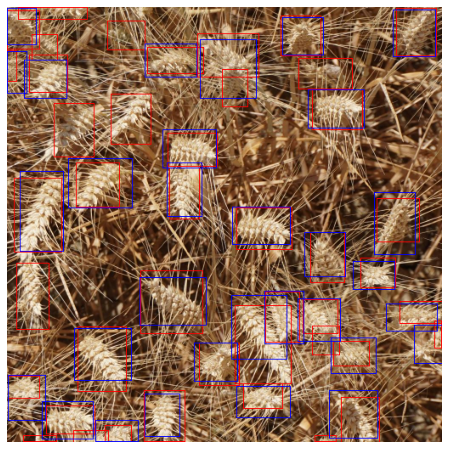

In [ ]:
#view_sample(df_folds[df_folds['fold'] == fold],threshold = 0.5,model=model,device=torch.device('cuda'))
#view_sample(df_folds[df_folds['fold'] == fold],threshold = 0.7,model=model,device=torch.device('cuda'))
view_sample(df_folds[df_folds['fold'] == fold],threshold = 0.9,model=model,device=torch.device('cuda'))

# Visualization of the Transformer component's attentional behavior for detected objects

In [ ]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c), (y_c),
         (x_c + w), (y_c + h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='r', linewidth=3))
        cl = p.argmax()
        text = f'Wheat: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
img_files = os.listdir(DIR_TRAIN)
im = Image.open(DIR_TRAIN + '/' + img_files[10])

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.8+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.8

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

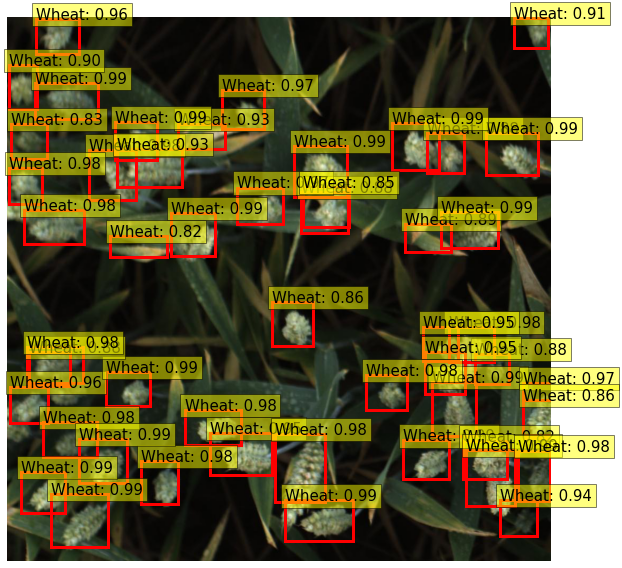

In [ ]:
plot_results(im, probas[keep], bboxes_scaled)

In [ ]:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

# propagate through the model
with torch.no_grad():
    outputs = model(img)

for hook in hooks:
    hook.remove()

# don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

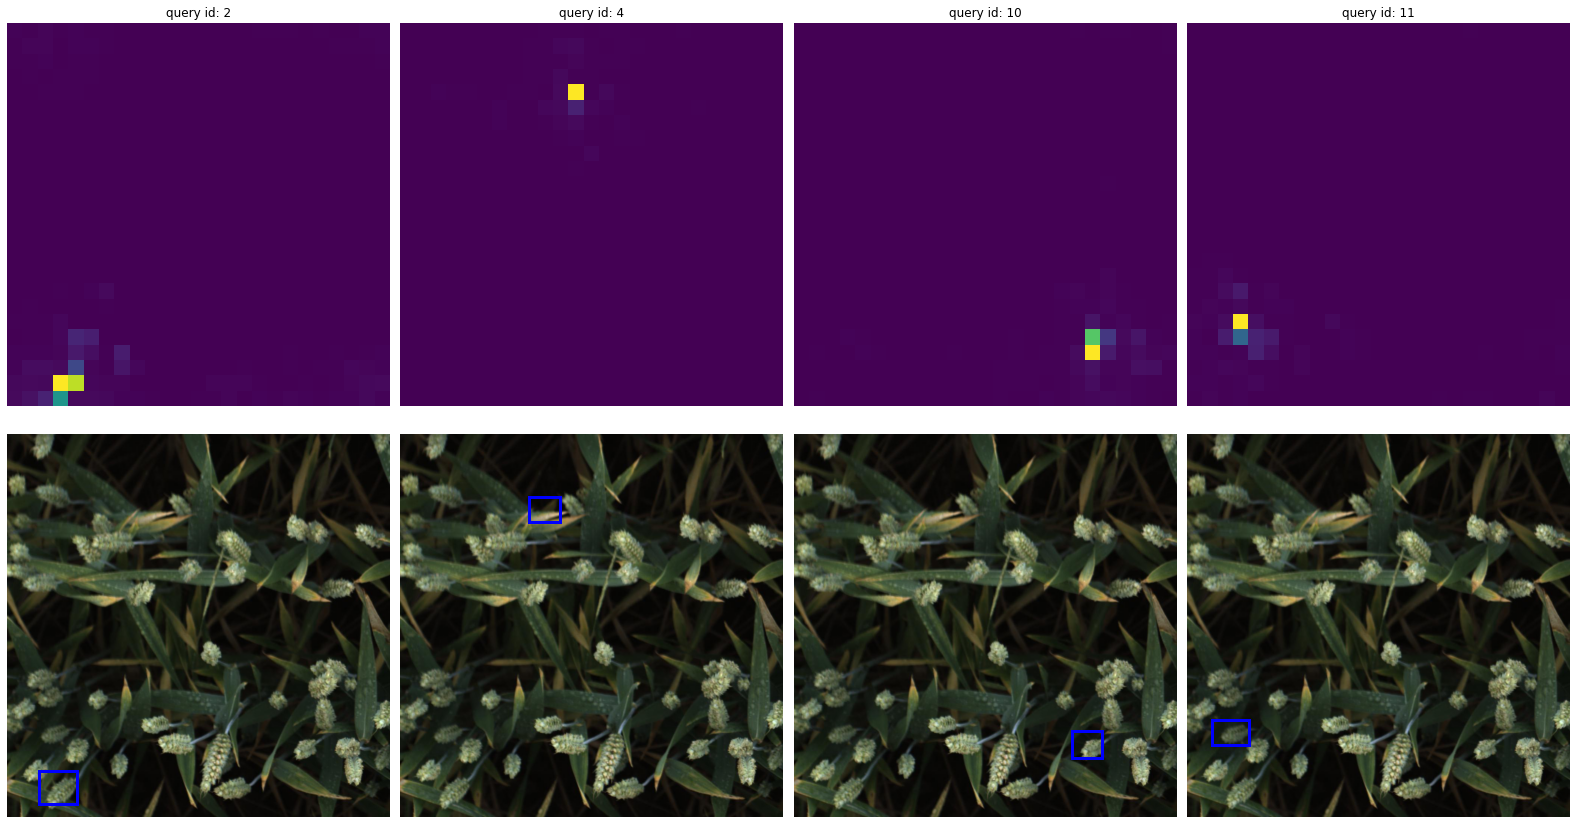

In [ ]:
# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

number_shown = 4   #len(bboxes_scaled)

fig, axs = plt.subplots(ncols=number_shown, nrows=2, figsize=(22, 12))

count = 0

for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    if count == number_shown:
        break
    count += 1
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    xmin, ymin, xmax, ymax = xmin.detach().numpy(), ymin.detach().numpy(), xmax.detach().numpy(), ymax.detach().numpy()
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
fig.tight_layout()

# Implement accuracy caldulations

In [ ]:
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box, shape (4,)
        pr: (np.ndarray[Union[int, float]]) coordinates of the predicted box, shape (4,)
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    # print("calculate iou and now values and shapes")
    # print(gt)
    # print(pr)
    # print(gt.shape)
    # print(pr.shape)
    # print(type(gt))
    # print(type(pr))
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area


def find_best_match(gts, pred, pred_idx, threshold=0.5, form='coco', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (np.ndarray) Coordinates of the available ground-truth boxes (n, 4)
        pred: (np.ndarray) Coordinates of the predicted box (1, 4)
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    # print(gts)
    # print(pred)
    # print(gts.shape)
    # print(pred.shape)
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue

        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)

            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

def calculate_precision(gts, preds, threshold=0.5, form='coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (np.ndarray) Coordinates of the available ground-truth boxes, shape (n, 4)
        preds: (np.ndarray) Coordinates of the predicted boxes, sorted by confidence value (descending), shape (m, 4)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) n x m matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    # print("welcome to calculate precision")
    # print(gts)
    # print(preds)
    # print(gts.shape)
    # print(preds.shape)

    n = len(preds)
    tp = 0
    fp = 0

    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)
        # print("best match idx")
        # print(best_match_gt_idx)
        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)

def calculate_image_precision(gts, preds, thresholds=(0.5,), form='coco') -> float:
    """Calculates image precision.

    Args:
        gts: (np.ndarray) Coordinates of the available ground-truth boxes, shape (n, 4)
        preds: (np.ndarray) Coordinates of the predicted boxes, shape (n, 4) sorted by confidence value (descending)
        thresholds: (tuple) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0

    ious = np.ones((len(gts), len(preds))) * -1

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision




In [ ]:
validation_image_precision = []
iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]

for images, targets, image_ids in valid_data_loader:
    # ...
    #
    # outputs = model.forward(images)
    #
    # ...
    #
    # preds = ... # shape: (#predicted box, 4)
    # scores = ... # shape: (#predicted box, )
    # gt_boxes = ... # shape: (#ground-truth box, 4)
    images = list(img.to('cpu') for img in images)
    with torch.no_grad():
        outputs = model(images)

    # preds_sorted_idx = np.argsort(scores)[::-1]
    # preds_sorted = preds[preds_sorted_idx]

    for idx, image in enumerate(images):
        #for a given image we have the ground truth, predictions,and scores
        gt_boxes = targets[idx]['boxes'].cpu().numpy()
        preds = outputs['pred_boxes'][idx].cpu().numpy()
        # print("preds before")
        # print(preds.shape)
        scores = outputs['pred_logits'][idx].cpu().numpy()
        #keep only the first values
        scores = scores[:,0]
        # print(scores.shape)
        threshold = 0.7
        keep = scores > threshold
        preds = preds[keep]
        # print("preds after")
        # print(preds.shape)
        image_precision = calculate_image_precision(preds,
                                                    gt_boxes,
                                                    thresholds=iou_thresholds,
                                                    form='coco')

        validation_image_precision.append(image_precision)
        print("image precision")
        print(image_precision)

#print("Validation IOU: {0:.4f}".format(np.mean(validation_image_precisions))
print("final image precision")
print(np.mean(validation_image_precision))

image precision
0.7441860465116279
image precision
0.7386779014137504
image precision
0.740469916556873
image precision
0.8284595881728165
image precision
0.8583702441904122
image precision
0.7904089741845866
image precision
0.6388888888888888
image precision
0.7849540396710207
image precision
0.7872054762324461
image precision
0.5567104776874892
image precision
0.7391304347826086
image precision
0.9473684210526316
image precision
0.7671171171171172
image precision
0.8587008060692272
image precision
0.7106066349789559
image precision
0.7923214696506622
image precision
0.8444541844995618
image precision
0.7965436466984455
image precision
0.84375
image precision
0.9347826086956522
image precision
0.8146320171904378
image precision
0.8112918043023583
image precision
0.7822972562518983
image precision
0.9999999999999999
image precision
0.7762513191617668
image precision
0.55
image precision
0.802156862745098
image precision
0.7165457209951093
image precision
0.7254807692307692
image precis